# Intro to RAPIDS using the New York City Yellow Taxi Data 
light on Data Science, heavy on comparisons.

This notebook is for the The Toronto Machine Learning Summit, Nov 16 -29, 2020

![TMLS](./img/TMLS.png)

This notebook includes

* cudf - for basic ETL and some __statistical analysis__ 
* cuml - for __machine learning__
* cugraph - for some __graph analysis__
* cuxfilter - for __visualization__


----
# Setup

In [1]:
# load the libraries
import cudf

import numpy as np
import pandas as pd
import math

import os
import gc

from collections import OrderedDict
import argparse
import datetime
import time

In [2]:
try: 
    import tqdm
except ModuleNotFoundError:
    os.system('pip install tqdm')
    import tqdm

In [3]:
# Let's use Unified Memory (aka managed memory) so that we try and avoid OOM errors 
# start by importing the RAPIDS Memory Manager and then reinitializing with managed memory turn on
import rmm

rmm.reinitialize(   
    managed_memory=True,        # Use managed memory, this allows for oversubscription of the GPU
    pool_allocator=False,       # default is False
    devices=0,                  # GPU device IDs to register. By default, registers only GPU 0.
)

## Download the data

In [4]:
top_dir = "./"
data_dir = "./nyctaxi"

----

# cuDF - Accelerated Data Frame 

In [5]:
# get a list of files
data_path = top_dir + "nyctaxi/2016"

files = []

for f in sorted(os.listdir(data_path)):
    if f[0:6] != 'yellow':
        continue
        
    fname = os.path.join(data_path, f)
            
    files.append(fname)


In [6]:
files

['./nyctaxi/2016/yellow_tripdata_2016-01.csv',
 './nyctaxi/2016/yellow_tripdata_2016-02.csv',
 './nyctaxi/2016/yellow_tripdata_2016-03.csv',
 './nyctaxi/2016/yellow_tripdata_2016-04.csv',
 './nyctaxi/2016/yellow_tripdata_2016-05.csv',
 './nyctaxi/2016/yellow_tripdata_2016-06.csv']

In [7]:
!du -sh $data_path

11G	./nyctaxi/2016


## Loading data performance test

In [8]:
def read_pandas(f):
    start_t = time.time()
    df = pd.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [9]:
def read_cudf(f):
    start_t = time.time()
    df = cudf.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [10]:
# Load data with Pandas

data = []

start_t = time.time()

file = files[:1]

for f in file:
    print("\treading " + f, end = '')
    df, t = read_pandas(f)
    print(" ... in time of " + str(t) + " seconds")
    data.append(df)
  
taxi_pdf = pd.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_pdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 25.40064549446106 seconds
loaded 10,906,858 records in 25.809836  seconds


In [12]:
# Load data with RAPIDS cuDF

data = []

start_t = time.time()

for f in files:
    print("\treading " + f, end = '')
    df, t = read_cudf(f)
    print(" ... in time of " + str(t)+ " seconds")
    data.append(df)

taxi_gdf = cudf.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_gdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 1.0667095184326172 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv ... in time of 1.1553757190704346 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-03.csv ... in time of 1.230755090713501 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-04.csv ... in time of 1.6224439144134521 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-05.csv ... in time of 1.7139256000518799 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-06.csv ... in time of 1.5988235473632812 seconds
loaded 69,406,520 records in 13.095456  seconds


In [13]:
taxi_gdf.head(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-01-01 00:00:00   2016-01-01 00:00:00                2   
1         2  2016-01-01 00:00:00   2016-01-01 00:00:00                5   
2         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
3         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
4         2  2016-01-01 00:00:00   2016-01-01 00:00:00                3   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.10        -73.990372        40.734695           1   
1           4.90        -73.980782        40.729912           1   
2          10.54        -73.984550        40.679565           1   
3           4.75        -73.993469        40.718990           1   
4           1.76        -73.960625        40.781330           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.981842         40.732407             2   
1                  N         -73.944473         40.716679             1   
2                  N         -73.950272         40.788925             1   
3                  N         -73.962242         40.657333             2   
4                  N         -73.977264         40.758514             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          7.5    0.5      0.5         0.0           0.0   
1         18.0    0.5      0.5         0.0           0.0   
2         33.0    0.5      0.5         0.0           0.0   
3         16.5    0.0      0.5         0.0           0.0   
4          8.0    0.0      0.5         0.0           0.0   

   improvement_surcharge  total_amount  
0                    0.3           8.8  
1                    0.3          19.3  
2                    0.3          34.3  
3                    0.3          17.3  
4                    0.3           8.8

## Sort Comparisons - Single Field

In [14]:
%%time
sp = taxi_pdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 7.15 s, sys: 217 ms, total: 7.37 s
Wall time: 7.35 s


In [15]:
%%time
sg = taxi_gdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 3.06 s, sys: 5.81 ms, total: 3.07 s
Wall time: 3.08 s


## Group By - Single Column 

In [16]:
%%time
gbp = taxi_pdf.groupby('passenger_count').count()

CPU times: user 2.88 s, sys: 489 ms, total: 3.36 s
Wall time: 3.37 s


In [17]:
%%time
gbg = taxi_gdf.groupby('passenger_count').count()

CPU times: user 5.84 s, sys: 430 ms, total: 6.27 s
Wall time: 6.27 s


## Fun with Data

In [18]:
%%time
print(f"Max fare was ${taxi_pdf['fare_amount'].max():,}")

Max fare was $111,270.85
CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 17.9 ms


In [19]:
%%time
print(f"Max fare was ${taxi_gdf['fare_amount'].max():,}")

Max fare was $628,544.74
CPU times: user 4.06 ms, sys: 3.09 ms, total: 7.15 ms
Wall time: 8.95 ms


In [20]:
# looking at that huge fare
maxf = taxi_gdf['fare_amount'].max()
taxi_gdf.query('fare_amount == @maxf')

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
10199130         1  2016-06-30 09:21:03   2016-06-30 09:21:03   
10203011         1  2016-06-30 09:28:53   2016-06-30 09:28:53   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
10199130                1            0.0        -73.872955        40.773994   
10203011                1            0.0        -73.928604        40.787613   

          RatecodeID store_and_fwd_flag  dropoff_longitude  dropoff_latitude  \
10199130           1                  N                0.0               0.0   
10203011           1                  N                0.0               0.0   

          payment_type  fare_amount   extra  mta_tax  tip_amount  \
10199130             2    628544.74  488.24      0.5         0.0   
10203011             2    628544.74  488.24      0.5         0.0   

          tolls_amount  improvement_surcharge  total_amount  
10199130           0.0                    0.3     629033.78  
10203011           0.0                    0.3     629033.78

In [21]:
print(f"Farthest trip was {taxi_gdf['trip_distance'].max():,} miles")

Farthest trip was 19,072,628.8 miles


In [22]:
# How long did it take to drive that distance?
maxd= taxi_gdf['trip_distance'].max()
taxi_gdf.query('trip_distance == @maxd')

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
8340109         1  2016-03-07 19:57:50   2016-03-07 20:16:21                1   

         trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
8340109     19072628.8        -73.995796        40.761204           1   

        store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
8340109                  Y         -73.995789         40.761208             2   

         fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
8340109          2.5    1.0      0.5         0.0           0.0   

         improvement_surcharge  total_amount  
8340109                    0.3           4.3

### Changing data types

In [23]:
# change some data types
taxi_gdf = taxi_gdf.astype({'tpep_pickup_datetime':'datetime64[ms]', 'tpep_dropoff_datetime':'datetime64[ms]'})

### Filtering data

In [24]:
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)" +
        "and (pickup_latitude != dropoff_latitude) " +
        "and (pickup_longitude != dropoff_longitude)"
    )

taxi_gdf = taxi_gdf.query(query_frags)

### Add some new features

In [25]:
# easier to reference time by YYYY MM DD version a time stamps
taxi_gdf['hour']  = taxi_gdf['tpep_pickup_datetime'].dt.hour
taxi_gdf['year']  = taxi_gdf['tpep_pickup_datetime'].dt.year
taxi_gdf['month'] = taxi_gdf['tpep_pickup_datetime'].dt.month
taxi_gdf['day']   = taxi_gdf['tpep_pickup_datetime'].dt.day
taxi_gdf['diff']  = taxi_gdf['tpep_dropoff_datetime'].astype('int64') - taxi_gdf['tpep_pickup_datetime'].astype('int64')

In [26]:
def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
taxi_gdf = taxi_gdf.apply_rows(
        day_of_the_week_kernel
        , incols = ['day', 'month', 'year']
        , outcols = {'day_of_week': np.int32}
        , kwargs = {}
    )

---

## Basic Statistical Data Science

### Look at some feature - by Hour

<AxesSubplot:xlabel='hour'>

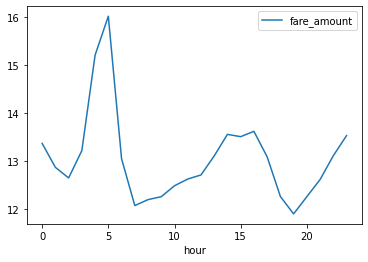

In [27]:
# 1) Let's look at a plot of fare by hour
%matplotlib inline
taxi_gdf.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='hour'>

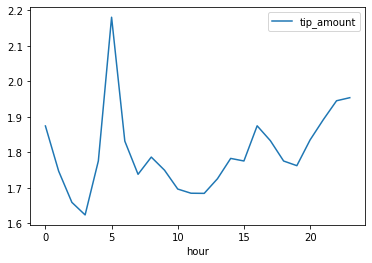

In [28]:
# 2) Tips by hour
%matplotlib inline
taxi_gdf.groupby('hour').tip_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='hour'>

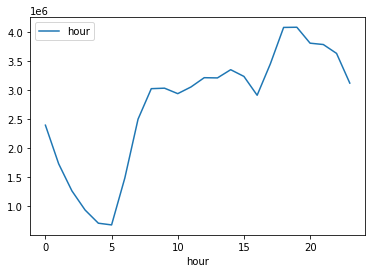

In [29]:
# 3) Number of taxi rides by Hour
%matplotlib inline
taxi_gdf['hour'].groupby('hour').count().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

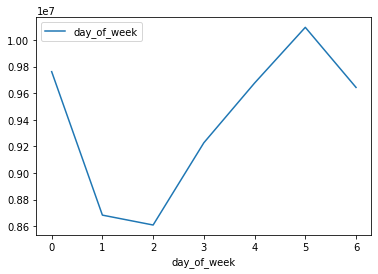

In [30]:
# Look at what days are the busiest
%matplotlib inline
taxi_gdf.groupby('day_of_week').day_of_week.count().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

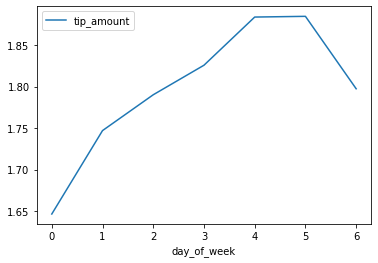

In [31]:
# What days have the best tips
%matplotlib inline
taxi_gdf.groupby('day_of_week').tip_amount.mean().to_pandas().sort_index().plot(legend=True)